<a href="https://colab.research.google.com/github/FelixSchmid/Reinforcement_Learning/blob/master/Q_learning_gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gridworld example with Q-learning and Sarsa

In [0]:
# importing the necessary libraries
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np

<img src="http://drive.google.com/uc?export=view&id=18q7KL4aV6McMtaid_1Let2aGkw6d4QYn" width=45%>

In [0]:
class GridWorld:
    """
    The environment: (see image)
    * cells: the agent can step on a cell. There is exactly one cell to start from.
    This is the top left corner. There is one terminal cell where the walking ends, 
    the agent can not leave it (blue).
    * obstacles: there are cells where the agent can not step. (gray)
    * agent: it can move from one cell to an other neighboring cell. 
    Possible directions: up, down, left, right. Each transition happens with probability 1.
    * reward: after each transition the agent receives -1 point. In the terminal cell, no reward
    received anymore.
    """
    def __init__(self, size, start_cell, obstacles, terminating_state):
        self.size = size
        self.start = start_cell
        self.obstacles = obstacles
        self.termin = terminating_state
        self.current_cell = self.start
    
    def reset(self):
        # ----- reset the current cell to the start cell to start again -----
        self.current_cell = self.start
    
    def transition(self, cell, action):
        # cell = (row, column) indices
        # action: 0 left, 1 up, 2 right, 3 down
        # returns: What will be the next state
        # Take care of the borders of the grid!

        r_current = cell[0]
        c_current = cell[1]
        
        # left
        if action == 0:
          cell = (r_current,c_current-1)
        # up
        if action == 1:
          cell = (r_current-1,c_current)
        # right
        if action == 2:
          cell = (r_current,c_current+1)
        # down
        if action == 3:
          cell = (r_current+1,c_current)

        if (cell[0], cell[1]) in self.obstacles:
          # undo step if we hit an obst.
          cell = (r_current,c_current)

        if cell[0] < 0 \
             or cell[0] > self.size[0] -1 \
             or cell[1] < 0  \
             or cell[1] > self.size[1] -1 : 
          # undo steps if we left the board
          cell = (r_current, c_current)
        
        # update the current_cell the step
        self.current_cell = cell
        
        return cell


    def reward(self, cell, action):
        # ----- RETURN REWARD -----
        # -1 if not in the terminal state
        cell_state = cell
        if self.transition(cell, action) != self.termin:
          reward = -1
        else:
          reward = 0
        # we only want to know the reward of a pot. transition
        # so we undo the action which is done within def transition that we call
        # for doing the transition, we need to call transition alone
        # probably there is a more elegant solution
        self.current_cell = cell_state
        return reward

    def in_terminal(self):
        return self.current_cell == self.termin

In [0]:
class QLearning:
    """
    In this class you can implement the Q-learning algorithm.
    The algorithm will run trajectories in the environment (grid world)
    and according to the transitions ()
    """
    def __init__(self, gridworld, gamma, alpha, episodes):
        self.gridworld = gridworld
        self.gamma = gamma
        self.alpha = alpha
        self.episodes = episodes
        # create table
        size = gridworld.size
        # create a numpy matrix for storing the q-values for each actions and states
        self.q_table =  self.q_table = np.zeros((4,) + size)   
        # epsilon greedy
        self.eps = 0.9
        self.episode = 0
        # performance summary
        self.sum_rewards = []
        self.path = []
    
    def update(self, cell, action, reward, next_cell):
        r_t, c_t = cell  # current state
        r_tp1, c_tp1 = next_cell  # next state
        # the update rule for q-learning
        q_current_step = self.q_table[action, r_t, c_t] 
        q_next_step = max(self.q_table[:, r_tp1, c_tp1])
        error_term = reward + self.gamma * q_next_step - q_current_step
        self.q_table[action, r_t, c_t] = q_current_step + self.alpha * (error_term)
    
    def choose_action(self, cell):
        r, c = cell
        # choose the next action accroding to epsilon-greedy 
        if np.random.random() > (1 - self.eps):
            action = np.argmax(self.q_table[:, r, c])
        else:
            action = np.random.randint(low=0, high=4)
        return action
    
    def anneal_epsilon(self):
        # The algo smoothly shifts from exploration to exploitation.
        self.eps = max(0, self.eps * (1 - self.episode / self.episodes * 1.5))
    
    def one_episode(self):  # plays an episode
        # This function is responsible for running the agent 
        # for one episode.
        # During each transition, the Q-function is updated.
        cntr = 0  # counter to avoid infinite loops when the agent stucks in the grid and can not reach the terminal state
        #  reset the gridworld 
        self.gridworld.reset()
        # append zero at the end of sum_rewards 
        self.sum_rewards.append(0)
        # cycle until termination (end of the current episode) or an upper limit (e.g. 5000)
        while not self.gridworld.in_terminal() and cntr < 5000:
            cntr += 1
            cell = self.gridworld.current_cell
            action = self.choose_action(cell)
            reward = self.gridworld.reward(cell, action)
            next_cell = self.gridworld.transition(cell, action)
            # update the q-table 
            self.update(cell, action, reward, next_cell)
            # add the reward to the last element in sum_rewards
            self.sum_rewards[-1] += reward

        self.episode += 1
        self.anneal_epsilon

    
    def trajectory(self):
        self.gridworld.reset()
        self.path = []
        sum_rewards = 0
        itr = 0
        while not self.gridworld.in_terminal() and itr < 20:
            r, c = self.gridworld.current_cell
            action = np.argmax(self.q_table[:, r, c])
            sum_rewards += self.gridworld.reward((r, c), action)
            self.gridworld.transition((r, c), action)
            itr += 1
            #print(itr)
            self.path.append((r, c))
        return sum_rewards

    def is_learning_finished(self):  # depands on the number of episodes
        return self.episode > self.episodes

In [0]:
class Sarsa:
    
    def __init__(self, gridworld, gamma, alpha, episodes):
        self.gridworld = gridworld
        self.gamma = gamma
        self.alpha = alpha
        self.episodes = episodes
        # create table
        size = gridworld.size
        # create a numpy matrix for storing the q-values for each actions and states
        self.q_table =  self.q_table = np.zeros((4,) + size) 
        # epsilon greedy
        self.eps = 0.9
        self.episode = 0
        # preformance summary
        self.sum_rewards = []
        self.path = []
    
    def update(self, cell, action, reward, next_cell, next_action):
        # the update rule for sarsa learning
        r_t, c_t = cell  # current state
        r_tp1, c_tp1 = next_cell  # next state
        # update rule 
        q_current_step = self.q_table[action, r_t, c_t] 
        q_next_step = self.q_table[next_action, r_tp1, c_tp1]
        error_term = reward + self.gamma * q_next_step - q_current_step
        self.q_table[action, r_t, c_t] = q_current_step + self.alpha * (error_term)
    
    def choose_action(self, cell):
        r, c = cell
        # choose the next action accroding to epsilon-greedy 
        if np.random.random() > (1 - self.eps):
            action = np.argmax(self.q_table[:, r, c])
        else:
            action = np.random.randint(low=0, high=4)
        return action
    
    def anneal_epsilon(self):
        # 1.5 - anneal earlier then the last episode
        self.eps = max(0, self.eps * (1 - self.episode / self.episodes * 1.5))
    
    def one_episode(self):  # plays an episode

        # Is it the first step of the episode?
        first_step = True
        cntr = 0
        self.gridworld.reset()
        self.sum_rewards.append(0)

        while not self.gridworld.in_terminal() and cntr < 5000:
            cntr += 1
            cell = self.gridworld.current_cell

            # ----- choose the action -----
            if first_step == True:
                action = self.choose_action(cell)
                first_step = False
            else:
                # ensures to take the action with which we updated the
                # q-table in the last round of the loop
                action = next_action

            # get the reward 
            reward = self.gridworld.reward(cell, action)
            # make one transition and store
            next_cell = self.gridworld.transition(cell, action)
            # update the q-table 
            next_action = self.choose_action(next_cell)
            self.update(cell, action, reward, next_cell, next_action)
            # add the reward to the last element in sum_rewards 
            self.sum_rewards[-1] += reward

        self.episode += 1
        self.anneal_epsilon
    
    def trajectory(self):
        self.gridworld.reset()
        self.path = []
        sum_rewards = 0
        itr = 0
        while not self.gridworld.in_terminal() and itr < 20:
            r, c = self.gridworld.current_cell
            action = np.argmax(self.q_table[:, r, c])
            sum_rewards += self.gridworld.reward((r, c), action)
            self.gridworld.transition((r, c), action)
            itr += 1
            self.path.append((r, c))
        return sum_rewards

    def is_learning_finished(self):
        return self.episode > self.episodes

In [0]:
def plot_learning_curve(ql):
    values = ql.sum_rewards
    x = list(range(len(values)))
    y = values
    plt.plot(x, y, 'ro')
    plt.show()

**Q-Learner**

-7


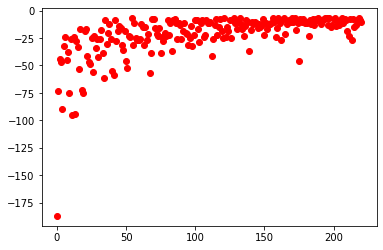

In [0]:
# grid world parameters
size = (6, 6)
start_cell = (0, 0)
obstacles = [(3, 3)]
terminating_state = (3, 5)
# q learning parameters
gamma = 0.9
alpha = 0.1
episodes = 220

gw = GridWorld(size, start_cell, obstacles, terminating_state)
solver = QLearning(gw, gamma, alpha, episodes)  # ----- try both of them -----
#solver = Sarsa(gw, gamma, alpha, episodes)

while not solver.is_learning_finished():
    solver.one_episode()
    sum_rewards = solver.sum_rewards[-1]
    #print(sum_rewards)

sum_rewards = solver.trajectory()
print(sum_rewards)
plot_learning_curve(solver)

**SARSA**

-7


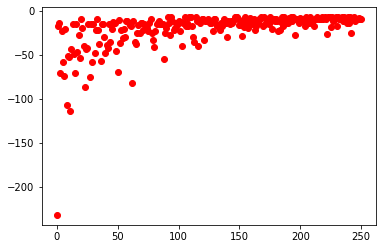

In [0]:
# grid world parameters
size = (6, 6)
start_cell = (0, 0)
obstacles = [(3, 3)]
terminating_state = (3, 5)
# q learning parameters
gamma = 0.9
alpha = 0.1
episodes = 250

gw = GridWorld(size, start_cell, obstacles, terminating_state)
#solver = QLearning(gw, gamma, alpha, episodes)  # ----- try both of them -----
solver = Sarsa(gw, gamma, alpha, episodes)

while not solver.is_learning_finished():
    solver.one_episode()
    sum_rewards = solver.sum_rewards[-1]
    #print(sum_rewards)

sum_rewards = solver.trajectory()
print(sum_rewards)
plot_learning_curve(solver)